In [1]:
import pathlib
import pickle
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from tqdm import tqdm

import importlib

In [2]:
import ensembles

importlib.reload(ensembles)

<module 'ensembles' from 'C:\\Users\\Vladimir\\PycharmProjects\\ML_Ensembles\\experiments\\ensembles\\__init__.py'>

In [3]:
data = pd.read_csv('kc_house_data.csv')

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
y = data.price.to_numpy()
X = data.drop(columns=['price'])
X['date'] = pd.to_datetime(X.date.apply(lambda s: f"{s[0:4]}-{s[4:6]}-{s[6:8]}")).apply(lambda dt: dt.value)
X.drop(columns='id', inplace=True)

X.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1413158400000000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1418083200000000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,1424822400000000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,1418083200000000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1424217600000000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


_sqft\_living_ --- жилая площадь (в квадратных футах)
_sqft\_lot_ --- площадь участка (в квадратных футах)
_waterfront_ --- дом у набережной или дом у озера, реки
_sqft\_living15_ --- средняя жилая площадь у ближайших 15 домов
_sqft\_lot15_ --- средняя площадь участка и ближайших 15 домов

In [5]:
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"{X_train.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(17290, 19)
X_test.shape=(4323, 19)


In [6]:
boosting = ensembles.GradientBoostingMSE(
    n_estimators=1_000,
    feature_subsample_size=6,
    random_state=42,
    max_depth=7,
    learning_rate=0.05
)

boosting.fit(X_train, y_train)

In [7]:
y_pred = boosting.predict(X_test)
print(f"MSE: {mean_squared_error(y_true=y_test, y_pred=y_pred):.0f}")
print(f"r^2: {r2_score(y_true=y_test, y_pred=y_pred):.4f}")

MSE: 18270389587
r^2: 0.8791


100%|██████████| 999/999 [02:07<00:00,  7.81it/s]


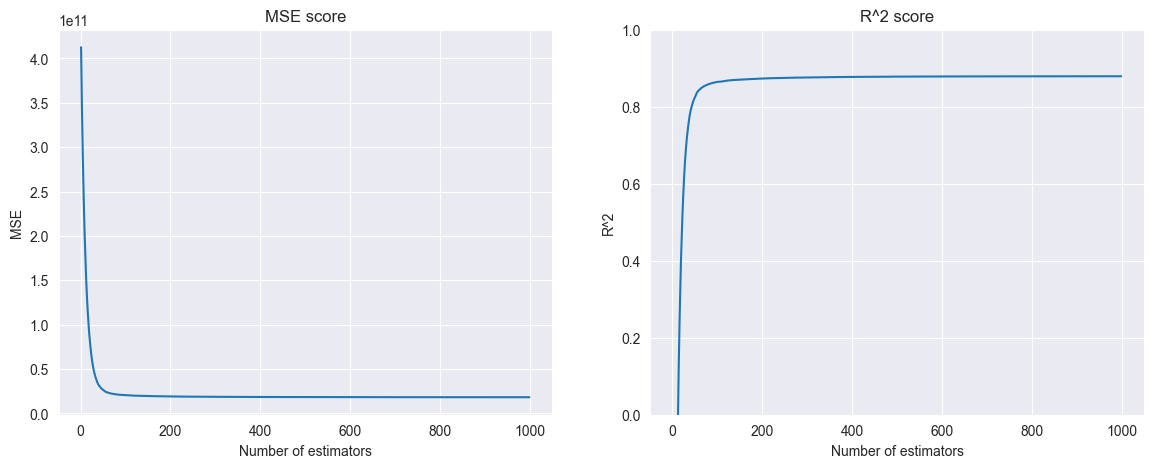

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

estimators_cnt = np.arange(1_000 - 1) + 1
mse_score_ls = np.zeros_like(estimators_cnt, dtype=np.float64)
r2_score_ls = np.zeros_like(estimators_cnt, dtype=np.float64)

for i in tqdm(estimators_cnt):
    y_pred = boosting.predict(X_test, estimators_c=i)
    mse_score_ls[i-1] = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2_score_ls[i-1] = r2_score(y_true=y_test, y_pred=y_pred)
    
ax[0].plot(estimators_cnt, mse_score_ls)
ax[0].set_xlabel("Number of estimators")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE score")

ax[1].plot(estimators_cnt, r2_score_ls)
ax[1].set_xlabel("Number of estimators")
ax[1].set_ylabel("R^2")
ax[1].set_title("R^2 score")
ax[1].set_ylim((0, 1))

fig.savefig("./figures/boosting_estimators_cnt.pdf")

In [15]:
path = pathlib.Path("./dumps/boosting_feat_subsample.pkl")

if not path.exists():
    feat_cnt = np.arange(X_train.shape[1] - 1) + 1
    mse_score_ls = np.zeros_like(feat_cnt, dtype=np.float64)
    r2_score_ls = np.zeros_like(feat_cnt, dtype=np.float64)
    
    for i in tqdm(feat_cnt):
        mse_score_raw = []
        r2_score_raw = []
        
        for seed in [42, 11, 5647, 456, 9195, 2023]:
            boosting = ensembles.GradientBoostingMSE(
                n_estimators=250,
                feature_subsample_size=i,
                random_state=seed,
                max_depth=7,
                learning_rate=0.05,
            )
            
            boosting.fit(X_train, y_train)
            y_pred = boosting.predict(X_test)
            
            mse_score_raw.append(mean_squared_error(y_true=y_test, y_pred=y_pred))
            r2_score_raw.append(r2_score(y_true=y_test, y_pred=y_pred))
        
        mse_score_ls[i-1] = np.mean(mse_score_raw)
        r2_score_ls[i-1] = np.mean(r2_score_raw)
    
    with open(path, "wb") as f:
        pickle.dump((feat_cnt, mse_score_ls, r2_score_ls), f)
else:
    with open(path, "rb") as f:
        feat_cnt, mse_score_ls, r2_score_ls = pickle.load(f)

100%|██████████| 18/18 [20:21<00:00, 67.89s/it] 


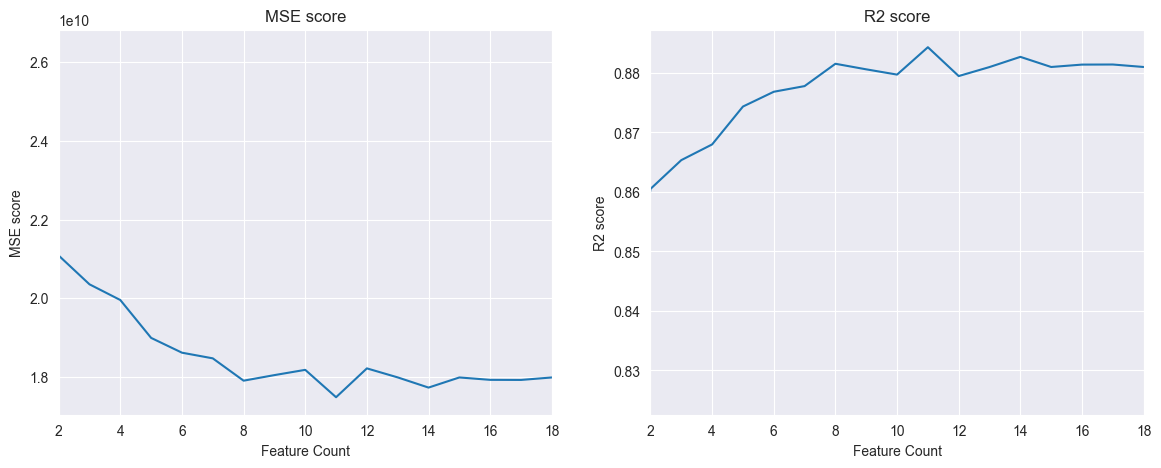

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].plot(feat_cnt, mse_score_ls)
ax[0].set_xlabel("Feature Count")
ax[0].set_ylabel("MSE score")
ax[0].set_title('MSE score')
ax[0].set_xlim([2, 18])

ax[1].plot(feat_cnt, r2_score_ls)
ax[1].set_xlabel("Feature Count")
ax[1].set_ylabel("R2 score")
ax[1].set_title('R2 score')
ax[1].set_xlim([2, 18])

fig.savefig('./figures/boosting_features_cnt.pdf')

In [11]:
path = pathlib.Path('./dumps/boosting_deep_search.pkl')

if not path.exists():
    depp = np.arange(15 - 1) + 1
    mse_score_ls = np.zeros_like(depp, dtype=np.float64)
    r2_score_ls = np.zeros_like(depp, dtype=np.float64)
    
    for i in tqdm(depp):
        mse_score_raw = []
        r2_score_raw = []
        
        for seed in [42, 11, 5647, 456, 9195, 2023]:
            boosting = ensembles.GradientBoostingMSE(
                n_estimators=250,
                feature_subsample_size=7,
                random_state=seed,
                max_depth=i,
                learning_rate=0.05,
            )
            
            boosting.fit(X_train, y_train)
            y_pred = boosting.predict(X_test)
            
            mse_score_raw.append(mean_squared_error(y_true=y_test, y_pred=y_pred))
            r2_score_raw.append(r2_score(y_true=y_test, y_pred=y_pred))
        
        # print(mse_score_raw, '\t', r2_score_raw, sep='')
        mse_score_ls[i-1] = np.mean(mse_score_raw)
        r2_score_ls[i-1] = np.mean(r2_score_raw)
    
    with open(path, "wb") as f:
        pickle.dump((depp, mse_score_ls, r2_score_ls), file=f)
else:
    with open(path, "rb") as f:
        depp, mse_score_ls, r2_score_ls = pickle.load(f)

100%|██████████| 14/14 [13:38<00:00, 58.45s/it]


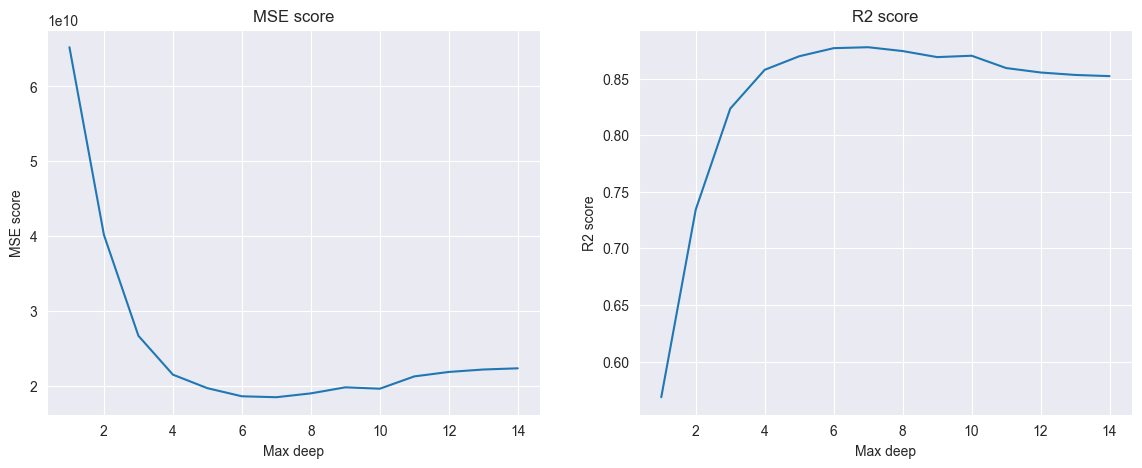

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].plot(depp, mse_score_ls)
ax[0].set_xlabel('Max deep')
ax[0].set_ylabel('MSE score')
ax[0].set_title('MSE score')

ax[1].plot(depp, r2_score_ls)
ax[1].set_xlabel('Max deep')
ax[1].set_ylabel('R2 score')
ax[1].set_title('R2 score')

fig.savefig('./figures/boosting_deep.pdf')

In [26]:
path = pathlib.Path('./dumps/boosting_lr_search.pkl')

if not path.exists():
    lr_ls = np.linspace(0.01, 0.5, num=12)
    mse_score_ls = np.zeros_like(lr_ls, dtype=np.float64)
    r2_score_ls = np.zeros_like(lr_ls, dtype=np.float64)
    
    for i in tqdm(range(lr_ls.shape[0])):
        mse_score_raw = []
        r2_score_raw = []
        
        for seed in [42, 11, 5647, 456, 9195, 2023]:
            boosting = ensembles.GradientBoostingMSE(
                n_estimators=250,
                feature_subsample_size=7,
                random_state=seed,
                max_depth=7,
                learning_rate=lr_ls[i],
            )
            
            boosting.fit(X_train, y_train)
            y_pred = boosting.predict(X_test)
            
            mse_score_raw.append(mean_squared_error(y_true=y_test, y_pred=y_pred))
            r2_score_raw.append(r2_score(y_true=y_test, y_pred=y_pred))
        
        # print(mse_score_raw, '\t', r2_score_raw, sep='')
        mse_score_ls[i] = np.mean(mse_score_raw)
        r2_score_ls[i] = np.mean(r2_score_raw)
    
    with open(path, "wb") as f:
        pickle.dump((lr_ls, mse_score_ls, r2_score_ls), file=f)
else:
    with open(path, "rb") as f:
        lr_ls, mse_score_ls, r2_score_ls = pickle.load(f)

100%|██████████| 10/10 [08:27<00:00, 50.73s/it]


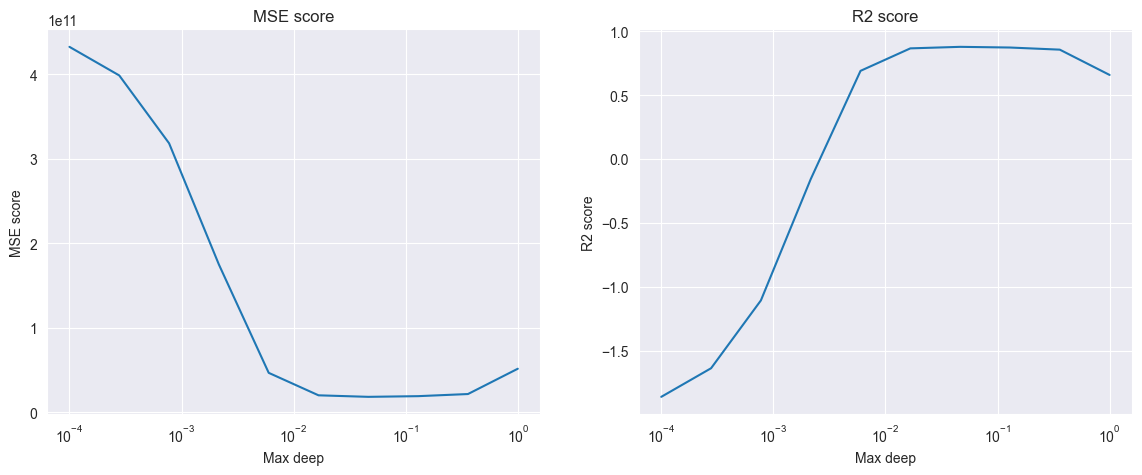

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].plot(lr_ls, mse_score_ls)
ax[0].set_xlabel('Max deep')
ax[0].set_ylabel('MSE score')
ax[0].set_title('MSE score')
ax[0].set_xscale('log')

ax[1].plot(lr_ls, r2_score_ls)
ax[1].set_xlabel('Max deep')
ax[1].set_ylabel('R2 score')
ax[1].set_title('R2 score')
ax[1].set_xscale('log')

fig.savefig('./figures/boosting_lr.pdf')

In [32]:
np.linspace(0.01, 0.5, num=12)

array([0.01      , 0.05454545, 0.09909091, 0.14363636, 0.18818182,
       0.23272727, 0.27727273, 0.32181818, 0.36636364, 0.41090909,
       0.45545455, 0.5       ])